# 프로젝트 : 뉴스 카테고리 다중분류
vocabulary의 크기에 따라 머신러닝 모델의 성능이 어떻게 변하는지 확인해보고, 최고의 성능이 나오는 머신러닝모델과 임의의 딥러닝 모델과 성능을 비교해보겠습니다.
# **First Try : num_words=10000**
# **Step1. Import Libraries**

In [ ]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

# **Step2. Import Data**
우리가 사용할 데이터는 reuter new data입니다. 이 데이터는 총 46개의 클래스로 구성되며, 해당 뉴스가 어느 카테고리에 속하는지를 예측하기 위한 데이터입니다. 텐서플로우 데이터셋에서 제공하고있는 데이터로 아주 쉽게 다운로드가 가능합니다.

In [ ]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

num_words는 이 데이터에서 빈도수 기준으로 상위 몇번째 단어까지 사용할 것인지 조절합니다.

# **Step3. EDA(Exploratory Data Analysis)**
받아온 데이터의 형태를 확인해봅시다.

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8982,), (2246,), (8982,), (2246,))

그럼 한번 출력을 해보죠

In [ ]:
print(x_train[:3])
print(y_train[:3])

[list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12])
 list([1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12])
 list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4, 78, 13, 68, 467, 511, 110, 59, 89, 90, 67, 139

텍스트가 아니라 숫자 시퀀스가 출력됩니다. 텐서플로우 데이터셋에서는 이미 전처리한 데이터를 제공해준다고 합니다.

그리고 레이블은 정수형태로 저장되있습니다. 그러면 몇개의 클래를 가지고 있는지 확인해봅시다.

In [ ]:
total_class = max(y_train) + 1 # 레이블이 숫자 0부터 시작되므로 1을 더해줌
print('클래스의 수 : {}'.format(total_class))

클래스의 수 : 46


클래스의 양이 많은것으로 보아 정확도를 얻는 일이 쉽지않아보입니다.

다음으로 뉴스 데이터들의 길이분포를 확인해봅시다.

훈련용 뉴스의 최대길이 : 2376
훈련용 뉴스의 평균길이 : 145.5398574927633


Text(0, 0.5, 'number of samples')

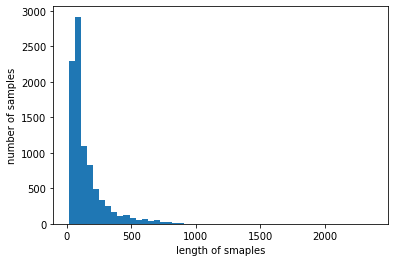

In [ ]:
print('훈련용 뉴스의 최대길이 : {}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균길이 : {}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of smaples')
plt.ylabel('number of samples')

대부분의 길이는 500미만에 몰려있는것으로 보입니다.

타깃레이블의 분포도 확인해봅시다. 

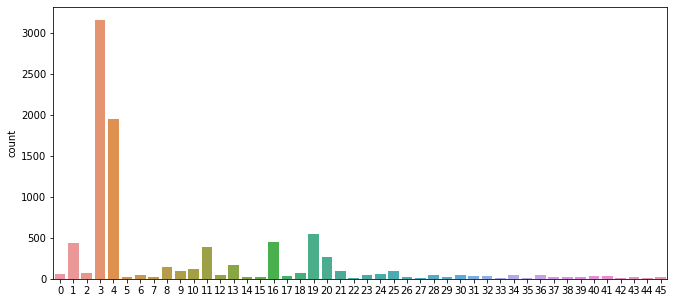

In [ ]:
plt.figure(figsize=(11,5))
sns.countplot(x=y_train)

이 뉴스 데이터는 3번,4번 클래스가 대부분을 차지하고 있습니다. 수치적으로도 정확히 몇개인지 출력해보겠습니다.

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print('각 클래스 빈도수:')
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


# **Step4. Restore from integer to text**
정수 시퀀스로 변환된 데이터를 다시 텍스트로 돌려보겠습니다. 이번 프로젝트에서는 딥러닝이 아닌 머신러닝 방법을 사용하여 벡터화를 진행할 것이기때문입니다. 
먼저 해당 데이터의 단어장(Vocabulary)를 불러와봅시다.

In [ ]:
word_index = reuters.get_word_index(path='reuters_word_index.json')

'the'와 'it'에 어떤 정수가 맵핑되어있는지 확인해봅시다.

In [ ]:
word_index['the']

1

In [ ]:
word_index['it']

13

우리는 정수로부터 단어를 얻는 index_word가 필요합니다. 
그리고 \<pad>,\<sos>,\<unk>의 토큰에 0번,1번,2번을 맵핑해줄것이기때문에 기존index에 전부 3을 더해주어야합니다.

In [ ]:
index_to_word = {index+3 : word for word, index in word_index.items()}

for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
    index_to_word[index] = token

그럼 index_to_word를 이용해서 첫번째 훈련용 뉴스 기사를 원래 텍스트로 복원해보겠습니다.

In [ ]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


첫번째 훈련용 뉴스기사가 정수 시퀀스에서 텍스트로 복원되었습니다. 이 데이터도 어느 정도 전처리가 된 상태라서, 자연스럽게 읽히지는 않습니다. 하지만 문맥을 가진 텍스트이기때문에, 이 데이터를 가지고 머신러닝을 시작해도 문제없어 보입니다.

이제 전체 훈련용, 테스트용 뉴스데이터를 텍스트데이터로 변환해 보겠습니다.

In [ ]:
# train dataset
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

# test dataset
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

8982
2246


제대로 변환이 됐는지 한번 출력해봅시다.

In [ ]:
x_train[1]

'<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3'

In [ ]:
x_test[1]

"<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> yulo said yulo told reuters a survey during the current milling season which ends next month showed the 1986 87 estimate would almost certainly be met he said at least 1 2 mln tonnes of the 1987 88 crop would be earmarked for domestic consumption yulo said about 130 000 tonnes would be set aside for the u s sugar quota 150 000 tonnes for strategic reserves and 50 000 tonnes would be sold on the world market he said if the government approved a long standing <unk> recommendation to manufacture ethanol the project would take up another 150 000 tonnes slightly raising the target the government for its own reasons has been delaying approval of the project but we expect it to come through by july yulo said ethanol could make up five pct of gasoline cutting the oil import bill by about 300 

# **Step5. Vectorizing**
텍스트 데이터가 있을 때, 모델의 입력으로 넣기 위해서는 우선 각 문서를 벡터화할 필요가 있습니다. 일반적으로 텍스트 분류를 할 모델로 인공 신경망을 사용하는 경우, 벡터화 방법 또한 인공 신경망을 사용하는것이 보편적입니다.(Eembedding)

여기서는 인공신경망이아닌 머신러닝을 사용하기때문에, 벡터화 방법도 인공신경망이 아닌 방법을 사용합니다. 여기서 사용할 벡터화 방법은 Bag of Words가설을 기반으로하는 DTM, TF-IDF입니다.

In [ ]:
# DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm = dtmvector.transform(x_test)
print(x_train_dtm.shape)

(8982, 9670)


이전에 num_words=10000을 사용했지만, DTM열의 개수는 이보다 적은수입니다. 그 이유는 DTM이 자체적인 규칙에 따라서 불필요하다고 판단하는 토큰들을 제거했기 때문입니다.

이어서 TF-IDF행렬을 만들어봅시다.

In [ ]:
# TF-IDF생성
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
tfidfv_test = tfidf_transformer.transform(x_test_dtm)
print(tfidfv.shape)

(8982, 9670)


추가적인 전처리를 하지 않는 이상, DTM과 동일한 크기를 가집니다.

# **Step6. Using various machine learning model**
다양한 머신러닝 모델을 사용해서 성능을 비교해보겠습니다.
1. Multinomial Naive Bayes Classifier(NB)
2. Complement Naive Bayes Classifier(CNB)
3. Logistic Regression
4. Linear Support Vector Machine
5. Decision Tree
6. Random Forest
7. GradientBoostingClassifier
8. Voting

## 1. Multinomial Naive Bayes Classifier(NB)
나이브 베이즈 분류기는 베이즈 정리에 기반한 통계적 분류 기법이고, feature끼리 서로독립이라는 조건이 필요합니다.

In [ ]:
model = MultinomialNB()
model.fit(tfidfv, y_train)
predicted = model.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.6567230632235085


## 2. Complement Naive Bayes Classifier(CNB)
NB는 독립변수가 '조건부로 독립적'이라는 가정을하기때문에, 문서가 특정분류에 속할 실제 확률을 사용할때 문제가 발생할 수 있습니다. 대부분의 샘플이 3번,4번 클래스에 치중해있기때문에, 데이터가 불균형합니다. 이 경우에 사용하는것이 CNB입니다. 이는 데이터의 불균형을 고려하여 가중치를 부여하는 특징을 가지고 있습니다. 따라서 일반적으로 CNB는 NB보다 성능이 좋습니다.

In [ ]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)
predicted = cb.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.7707034728406055


## 3. Logistic Regression
로지스틱 회귀는 소프트맥스함수를 사용한 다중 클래스 분류 알고리즘을 지원합니다. 주의할점은 이름이 회귀이지만, 실제로는 분류를 수행한다는 점입니다.

In [ ]:
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)
predicted = lr.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.8107747105966162


## 4. Linear Support Vector Machine(SVM)
LinearSVM은 태생적으로 이진분류를 위한 모델입니다. 그런데 이진분류 알고리즘을 다중클래스분류 알고리즘으로 사용하는 방법이 있습니다. 각 클래스를 다른 모든클래스와 구분하도록 이진분류모델을 학습시켜면 되죠. 결국 클래스의 수만큼 이진분류모델이 만들어집니다. 

In [ ]:
lsvc = LinearSVC(C=10000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)
predicted = lsvc.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.7733748886910062


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


## 5. Decision Tree
결정트리는 분류와 회귀문제에 널리 사용하는 모델입니다. 기본적으로 결정트리는 결정에 다다르기 위해 '예/아니오'질문을 이어나가면서 학습하죠. 하지만 트리계열의 모델들은 고차원이고 희소한 데이터에 대해서는 성능이 나오지 않는다는 특징이있습니다. 따라서 DTM이나 TF-IDF행렬의 경우 고차원이면서 sparse하기때문에 성능이 별로 나오지 않습니다.

In [ ]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)
predicted = tree.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.6202137132680321


## 6. Random Forest
결정트리는 훈련데이터에 과적합되는 경향이있습니다. 랜덤포레스트는 이 문제를 앙상블로 해결합니다. 가령 서로 다른 방향으로 과적합된 트리들을 조합하면 오히려 모델전체에서는 과적합을 피할수 있죠.

In [ ]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)
predicted = forest.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.674087266251113


## 7. GradientBoostingClassifier
그래디언트 부스팅트리는 여러개의 결정 트리를 묶어 만드는 앙상블 모델입니다. 랜덤포레스트와 다르게 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만듭니다. 그래디언트 부스팅 트리는 일부 특성을 무시한다는 특징을 갖고있습니다. 그래서 보통 랜덤포레스트를 먼저 사용해보고, 성능이나 예측 시간면에서 만족스럽지 않은 경우에 그래디언트 부스팅 트리를 사용하는것이 좋습니다.
###장점
- 메모리적게사용
- 예측이 빠름

###단점
- 훈련시간이 느림
- 희소한 고차원 데이터에서는 성능이 낮음

In [ ]:
grbt = GradientBoostingClassifier(random_state=0)
grbt.fit(tfidfv, y_train)
predicted = grbt.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.7662511130899377


## 8. Voting
캐글에서 상위권을 차지한 많은 솔루션들이 앙상블이라는 방법을 사용합니다. 그중에서 투표를 통해 결과를 도출하는 보팅이라는 방법을 사용합니다.
### hard Voting
: 결과물에 대한 최종값을 투표해서 결정

### Soft Voting
: 결과물이 나올 확률값을 다 더해서 최종 결과물에 대한 각각의 확률을 구한뒤 최종값을 도출

로지스틱회귀,CNB,그래디언트 부스팅 트리를 사용하여 소프트보팅을 해봅시다.

In [ ]:
voting_classifier = VotingClassifier(estimators=[
    ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
    ('cb', ComplementNB()),
    ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft')
voting_classifier.fit(tfidfv, y_train)
predicted = voting_classifier.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.8165627782724845


# **Step7. Performance Comparison**

|num_words=10000|accuracy|
|:----:|:----:|
|Naive Bayes Classifier|0.656|
|Complement Naive Bayes Classifier|0.771|
|Logistic Regression|0.811|
|LinearSVC|0.773|
|DecisionTree|0.620|
|RandomForest|0.674|
|Gradient BoostingTree|0.766|
|Soft Voting|0.817|

로지스틱회귀와 소프트보팅이 80%이상의 정확도를 보여줍니다.

# **Second Try : num_words=6000**
단어장의 크기를 6000으로 줄여서 이전 메커니즘을 그대로 수행해보겠습니다.

In [ ]:
# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=6000, test_split=0.2)

# 정수시퀀스 텍스트로 변환
word_index = reuters.get_word_index(path='reuters_word_index.json')
index_to_word = {index+3 : word for word, index in word_index.items()}

for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
    index_to_word[index] = token

# train dataset
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

# test dataset
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

8982
2246


In [ ]:
# 벡터화
# DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm = dtmvector.transform(x_test)

# TF-IDF생성
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
tfidfv_test = tfidf_transformer.transform(x_test_dtm)
print(tfidfv.shape)

(8982, 5844)


In [ ]:
# 1. Multinomial Naive Bayes Classifier(NB)
model = MultinomialNB()
model.fit(tfidfv, y_train)
predicted = model.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.6691896705253785


In [ ]:
# 2. Complement Naive Bayes Classifier(CNB)
cb = ComplementNB()
cb.fit(tfidfv, y_train)
predicted = cb.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.7689225289403384


In [ ]:
# 3. Logistic Regression
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)
predicted = lr.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.8076580587711487


In [ ]:
# 4. Linear Support Vector Machine(SVM)
lsvc = LinearSVC(C=10000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)
predicted = lsvc.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.7702582368655387


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
# 5. Decision Tree
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)
predicted = tree.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.6260017809439002


In [ ]:
# 6. Random Forest
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)
predicted = forest.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.6874443455031166


In [ ]:
# 7. GradientBoostingClassifier
grbt = GradientBoostingClassifier(random_state=0)
grbt.fit(tfidfv, y_train)
predicted = grbt.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.7644701691896705


In [ ]:
# 8. Voting
voting_classifier = VotingClassifier(estimators=[
    ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
    ('cb', ComplementNB()),
    ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft')
voting_classifier.fit(tfidfv, y_train)
predicted = voting_classifier.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.8138913624220837


|num_words=6000|accuracy|
|:----:|:----:|
|Naive Bayes Classifier|0.669|
|Complement Naive Bayes Classifier|0.769|
|Logistic Regression|0.807|
|LinearSVC|0.770|
|DecisionTree|0.626|
|RandomForest|0.687|
|Gradient BoostingTree|0.764|
|Soft Voting|0.813|

전반적으로 값이 내려갔습니다.

# **Third try : num_words=14000**

In [ ]:
# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=14000, test_split=0.2)

# 정수시퀀스 텍스트로 변환
word_index = reuters.get_word_index(path='reuters_word_index.json')
index_to_word = {index+3 : word for word, index in word_index.items()}

for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
    index_to_word[index] = token

# train dataset
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

# test dataset
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

8982
2246


In [ ]:
# 벡터화
# DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm = dtmvector.transform(x_test)

# TF-IDF생성
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
tfidfv_test = tfidf_transformer.transform(x_test_dtm)
print(tfidfv.shape)

(8982, 13341)


In [ ]:
# 1. Multinomial Naive Bayes Classifier(NB)
model = MultinomialNB()
model.fit(tfidfv, y_train)
predicted = model.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.6393588601959038


In [ ]:
# 2. Complement Naive Bayes Classifier(CNB)
cb = ComplementNB()
cb.fit(tfidfv, y_train)
predicted = cb.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.7733748886910062


In [ ]:
# 3. Logistic Regression
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)
predicted = lr.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.8138913624220837


In [ ]:
# 4. Linear Support Vector Machine(SVM)
lsvc = LinearSVC(C=10000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)
predicted = lsvc.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.763579697239537


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
# 5. Decision Tree
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)
predicted = tree.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.6179875333926982


In [ ]:
# 6. Random Forest
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)
predicted = forest.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.6580587711487088


In [ ]:
# 7. GradientBoostingClassifier
grbt = GradientBoostingClassifier(random_state=0)
grbt.fit(tfidfv, y_train)
predicted = grbt.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.7729296527159395


In [ ]:
# 8. Voting
voting_classifier = VotingClassifier(estimators=[
    ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
    ('cb', ComplementNB()),
    ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft')
voting_classifier.fit(tfidfv, y_train)
predicted = voting_classifier.predict(tfidfv_test)
print('accuracy :', accuracy_score(y_test, predicted))

accuracy : 0.8174532502226179


|num_words=14000|accuracy|
|:----:|:----:|
|Naive Bayes Classifier|0.639|
|Complement Naive Bayes Classifier|0.773|
|Logistic Regression|0.814|
|LinearSVC|0.764|
|DecisionTree|0.618|
|RandomForest|0.658|
|Gradient BoostingTree|0.773|
|Soft Voting|0.817|

전반적으로 값이 올라갔습니다.

# **Step8. Total Performance Comparison**
단어장의 크기에 따른 모델의 성능을 비교해보겠습니다. 

|Machine Learning Model|accuracy_6000|accuracy_10000|accuracy_14000|
|:----:|:----:|:----:|:----:|
|Naive Bayes Classifier|0.669|0.656|0.639|
|Complement Naive Bayes Classifier|0.769|0.771|0.773|
|Logistic Regression|0.807|0.811|0.814|
|LinearSVC|0.770|0.773|0.764|
|DecisionTree|0.626|0.620|0.618|
|RandomForest|0.687|0.674|0.658|
|Gradient BoostingTree|0.764|0.766|0.773|
|Soft Voting|0.813|0.816|0.817|

- Naive Bayes, DecisionTree, RandomForest는 단어장의 크기가 커질수록 성능이 줄어듬
- CNB, LogisticRegression, GradientBoostingTree, Voting은 단어장의 크기가 커질수록 성능이 늘어남
- 제일 높은 성능 모델 : num_words=14000, Voting, accuracy=0.817

# **Step9. Performance Comparison with DeepLearning Model**
위 과정을 통해 나온 최적의 모델과 단어 수 조건에서, 딥러닝모델을 적용한 결과와 비교해 봅시다.


In [ ]:
# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=14000, test_split=0.2)

해당 데이터는 이미 전처리가된 정수시퀀스 형태입니다. 따라서 바로 패딩을 적용해주겠습니다.

In [ ]:
# 패딩
x_train = pad_sequences(x_train,
                        value=0,
                        padding='pre',
                        maxlen=300)
x_test = pad_sequences(x_test,
                       value=0,
                       padding='pre',
                       maxlen=300)

In [ ]:
# 원핫인코딩을 해줍시다
from keras.utils.np_utils import to_categorical

one_hot_y_train = to_categorical(y_train)
one_hot_y_test = to_categorical(y_test)

데이터는 준비되었으므로, 이제 모델을 설계하고 훈련을 진행해봅시다.

In [ ]:
# 모델설계
vocab_size = 8000
word_vector_dim = 100

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(46, activation='softmax'))

model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, None, 100)         800000    
                                                                 
 lstm_41 (LSTM)              (None, 64)                42240     
                                                                 
 dense_154 (Dense)           (None, 64)                4160      
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_155 (Dense)           (None, 64)                4160      
                                                                 
 dense_156 (Dense)           (None, 46)                2990      
                                                                 
Total params: 853,550
Trainable params: 853,550
Non-t

In [ ]:
# 모델훈련
epochs = 35

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, one_hot_y_train,
         epochs=epochs,
         batch_size=128,
         validation_data=(x_test, one_hot_y_test),
         verbose=1)

Epoch 1/35
71/71 [==============================] - 4s 31ms/step - loss: 2.8543 - accuracy: 0.3351 - val_loss: 2.1496 - val_accuracy: 0.4568
Epoch 2/35
71/71 [==============================] - 2s 23ms/step - loss: 1.9311 - accuracy: 0.4706 - val_loss: 1.7910 - val_accuracy: 0.5583
Epoch 3/35
71/71 [==============================] - 2s 23ms/step - loss: 1.7561 - accuracy: 0.5024 - val_loss: 1.7523 - val_accuracy: 0.5356
Epoch 4/35
71/71 [==============================] - 2s 23ms/step - loss: 1.6382 - accuracy: 0.5571 - val_loss: 1.7418 - val_accuracy: 0.5401
Epoch 5/35
71/71 [==============================] - 2s 23ms/step - loss: 1.5218 - accuracy: 0.5755 - val_loss: 1.7103 - val_accuracy: 0.5516
Epoch 6/35
71/71 [==============================] - 2s 23ms/step - loss: 1.4396 - accuracy: 0.5993 - val_loss: 1.7352 - val_accuracy: 0.5797
Epoch 7/35
71/71 [==============================] - 2s 23ms/step - loss: 1.4352 - accuracy: 0.5912 - val_loss: 1.6948 - val_accuracy: 0.5810
Epoch 8/35
71

In [ ]:
model.evaluate(x_test, one_hot_y_test)

71/71 [==============================] - 1s 9ms/step - loss: 2.5807 - accuracy: 0.6411


[2.5807442665100098, 0.641139805316925]

해당 딥러닝모델은 성능이 62%정도밖에 나오지않는다. 

# 회고
- 텐서플로우 데이터셋의 신기한점은 텍스트데이터가아니라 정수시퀀스가 주어진다는 점이다. 모델의 성능을 확인하려할때 따로 전처리를 해주지 않아도 되는점이 편리한거같다.
- 이번노드를 진행하면서 많은 머신러닝모델을 사용해 볼 수 있어서 좋았다. 매번 딥러닝모델만 보다보니까 머신러닝을 까먹어가고있었는데 이번 노드를 통해 다시한번 상기시킬 수 있었다.
- 좋은 성능을 보인 모델은 로지스틱회귀랑 소프트보팅이다. 조금더 높은 성능을 보인것은 소프트보팅이지만, 나는 로지스틱회귀가 좀 더 마음에 든다. 왜냐하면 학습시간때문이다. 보팅은 학습시키는데 무려 20분이상이 걸렸다. 데이터가 별로 안커서망정이지 데이터가 좀 컷다면 시간을 매우 많이 잡아먹었을것이다. 그에반해 로지스틱회귀는 10분을 넘어간적이없다. 빠른 학습시간에 좋은 성능까지,가성비가 좋은거같다.
- 마지막으로 딥러닝모델을 설계해보고, 머신러닝 작업에서 사용했던 동일한 크기의 단어장과 동일한 데이터셋으로 딥러닝 성능을 확인해보는것이었다. 여기서 많은 시간을 할애했다. 모델 설계를 이리저리 바꿔보고, 패딩이나, 옵티마이저, 손실함수 등등 안건드려본게 없는것같다. 이런저런 수정을하다보니 50번이상의 모델설계를 하게되었다. 그럼에도불구하고 모델의 정확도가 70%를 넘긴적이없다...원래이런건지 내가 잘못설계한건지...다른분들이한것을 참조해보았다. 어떤분은 정확도가 80%를 넘겼길래 내가쓴 코드와 비교해보았더니 두가지 차이점이있었다. 첫번째로 계층의 깊이가 나보다 작았다. 이해는 할 수 없었지만 나도 한번 계층의 깊이를 훨씬 낮추어서 학습을 진행해보았지만 큰 성능의 향상은 없었다. 두번째는 벡터화과정이다. 나는 임베딩계층을 이용해서 벡터화를 진행했지만, 이분은 임베딩 계층을 사용하지않고, 정답레이블뿐만아니라 입력데이터도 원핫벡터로 표현한것이다. 말그대로 입력값과 정답레이블이 전부 0과1로 이루어진 데이터를 모델에 넣었던 것이다...데이터가 작았었기때문에 가능한방법인것같다(나도 다음에 써먹어봐야겠다)